In [1]:
import matplotlib 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helper import *
from tqdm import tqdm_notebook
import brainconn as bc
import pandas as pd
import seaborn as sns
import nilearn.plotting as plotting
import palettable as pal
import matplotlib.colors as mcolors

In [2]:
conn_mat, labels, dist_mat, g_conn = load_marmoset_data()
randnet_list = load_pickle_file('data/randnet_1000.pickle')
# randnet_list = load_pickle_file('data/randnet_5000.pickle')

In [3]:
cmap_seq2 = mcolors.LinearSegmentedColormap.from_list('',
                                                      pal.cmocean.sequential.Deep_20.mpl_colors[4:-4])
cmap_seq2_r = mcolors.LinearSegmentedColormap.from_list('',
                                                      pal.cmocean.sequential.Deep_20.mpl_colors[4:-4][::-1])

In [4]:
def tweak_fig(fig, ax, im):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.set_alpha(1)
    cb.ax.tick_params(labelsize=14) 
    # cb.set_ticks([])
    cb.draw_all()
    cb.outline.set_visible(False)
    sns.despine(top=True, right=True, left=False, bottom=False)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)

/home/labuser/miniconda3/envs/ni/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


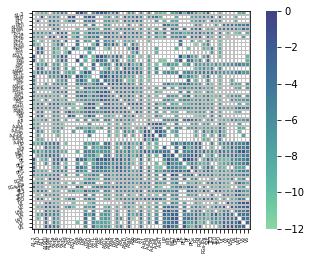

In [5]:
fig, ax = plt.subplots()
coll = ax.pcolormesh(np.log(conn_mat), edgecolor='silver', lw=0.5, cmap=cmap_seq2)
coll.set_clim(-12, 0)
ax.set_xticks(np.arange(len(labels))+0.5)
ax.set_yticks(np.arange(len(labels))+0.5)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=15)
ax.invert_yaxis()
ax.set_aspect("equal")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(4.5)
# for side in ['top', 'right', 'left', 'bottom']:
#     ax.spines[side].set_visible(False)
cb = ax.figure.colorbar(coll)
cb.outline.set_visible(False)

/home/labuser/miniconda3/envs/ni/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


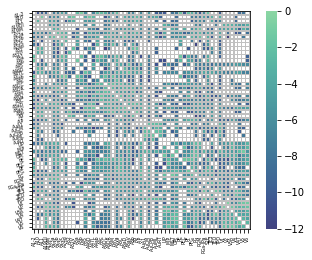

In [6]:
fig, ax = plt.subplots()
coll = ax.pcolormesh(np.log(conn_mat), edgecolor='silver', lw=0.5, cmap=cmap_seq2_r)
coll.set_clim(-12, 0)
ax.set_xticks(np.arange(len(labels))+0.5)
ax.set_yticks(np.arange(len(labels))+0.5)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=15)
ax.invert_yaxis()
ax.set_aspect("equal")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(4.5)
# for side in ['top', 'right', 'left', 'bottom']:
#     ax.spines[side].set_visible(False)
cb = ax.figure.colorbar(coll)
cb.outline.set_visible(False)

In [9]:
edge_btw_cent, _ = bc.centrality.edge_betweenness_wei(np.divide(1, conn_mat))
eb_df = pd.DataFrame(data={
    'weight': np.log(conn_mat).flatten(),
    'distance': dist_mat.flatten(),
    'edge_btw_cent': edge_btw_cent.flatten()
})
eb_df.replace([np.inf, -np.inf], np.nan)
eb_df.dropna(subset=['weight'], how='all')

X, y = dist_mat.flatten(), conn_mat.flatten()

from scipy.optimize import curve_fit
def str_func(x, a, b):
    return a * np.exp(b * x)

popt, pcov = curve_fit(str_func, X, y, p0=(0.1, -0.2))
# popt, pcov = curve_fit(str_func, fc_str, zfc_str, p0=(2, 0.04)) # for macaque
ss_res = np.sum((y - str_func(X, *popt)) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - (ss_res / ss_tot)

/home/labuser/miniconda3/envs/ni/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/labuser/miniconda3/envs/ni/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


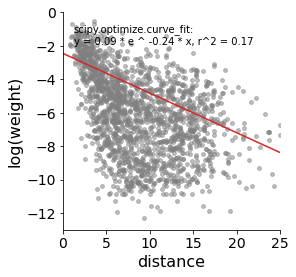

In [10]:
fig, ax = plt.subplots()
im = ax.scatter(eb_df['distance'], eb_df['weight'], alpha=0.5, s=15, color='gray')
ax.set_xlabel('distance', fontsize=16)
ax.set_ylabel('log(weight)', fontsize=16)
ax.set_xlim(0, 25)
ax.set_ylim(-13, 0)

x = np.arange(0, np.max(X), 0.1)
plt.plot(x, np.log(str_func(x, *popt)), color='tab:red')
ax.annotate(f'scipy.optimize.curve_fit:\n'
                f'y = {popt[0]:.2f} * e ^ {popt[1]:.2f} * x, r^2 = {r2:.2f}\n',
                xy=(.05, .8), xycoords=ax.transAxes)

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*1)

sns.despine(top=True, right=True, left=False, bottom=False)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)

In [11]:
recip = corrcoef_matrices(conn_mat, conn_mat.T)
recip_rand = [corrcoef_matrices(_, _.T) for _ in randnet_list]
#
assort_1 = bc.core.assortativity_wei(conn_mat, flag=1)
assort_1_rand = [bc.core.assortativity_wei(_, flag=1) for _ in randnet_list]
#
cluster_coef = np.mean(bc.clustering.clustering_coef_wd(conn_mat))
cluster_coef_rand = [np.mean(bc.clustering.clustering_coef_wd(_)) for _ in randnet_list]
#
shortest_path_mat = bc.distance.distance_bin(conn_mat)
charpath_length = bc.distance.charpath(shortest_path_mat)[0]
charpath_length_rand = [bc.distance.charpath(bc.distance.distance_bin(_))[0] for _ in randnet_list]

[Text(0, 1, 'characteristic\npath length')]

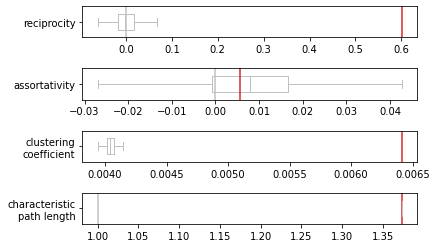

In [12]:
fig, axes = plt.subplots(4, 1)
axes = iter(axes.flatten())
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

ax = next(axes)
ax.boxplot(recip_rand, vert=False, widths=0.5, 
           boxprops={'color': 'silver'}, medianprops={'color': 'silver'}, 
           capprops={'color': 'silver'}, whiskerprops={'color': 'silver'}, showfliers=False)
ax.axvline(x=0, color='silver')
ax.axvline(x=recip, color='tab:red')
# sns.despine(ax=ax, top=True, right=True, left=True, bottom=False, offset=10, trim=False)
ax.set_yticklabels(["reciprocity"])


ax = next(axes)
ax.boxplot(assort_1_rand, vert=False, widths=0.5, 
           boxprops={'color': 'silver'}, medianprops={'color': 'silver'}, 
           capprops={'color': 'silver'}, whiskerprops={'color': 'silver'}, showfliers=False)
ax.axvline(x=0, color='silver')
ax.axvline(x=assort_1, color='tab:red')
# sns.despine(ax=ax, top=True, right=True, left=True, bottom=False, offset=10, trim=False)
ax.set_yticklabels(["assortativity"])


ax = next(axes)
ax.boxplot(cluster_coef_rand, vert=False, widths=0.5, 
           boxprops={'color': 'silver'}, medianprops={'color': 'silver'}, 
           capprops={'color': 'silver'}, whiskerprops={'color': 'silver'}, showfliers=False)
# ax.axvline(x=0, color='silver')
ax.axvline(x=cluster_coef, color='tab:red')
# sns.despine(ax=ax,top=True, right=True, left=True, bottom=False, offset=10, trim=False)
ax.set_yticklabels(["clustering\ncoefficient"])


ax = next(axes)
ax.boxplot(charpath_length_rand, vert=False, widths=0.5, 
           boxprops={'color': 'silver'}, medianprops={'color': 'silver'}, 
           capprops={'color': 'silver'}, whiskerprops={'color': 'silver'}, showfliers=False)
ax.axvline(x=1, color='silver')
ax.axvline(x=charpath_length, color='tab:red')
# sns.despine(top=True, right=True, left=True, bottom=False, offset=10, trim=False)
ax.set_yticklabels(["characteristic\npath length"])


In [13]:
spl_wei, _, _ = bc.distance.distance_wei_floyd(conn_mat, transform="log")
charpath_length_wei = bc.distance.charpath(spl_wei)[0]
charpath_length_wei_rand = [bc.distance.charpath(bc.distance.distance_wei_floyd(_, transform="log")[0])[0] for _ in randnet_list]

/home/labuser/Downloads/repos-install/brainconn/brainconn/distance/distance.py:394: RuntimeWarning: divide by zero encountered in log
  SPL = -np.log(adjacency)


In [14]:
norm1 = cluster_coef / np.mean(cluster_coef_rand)
norm2 = charpath_length_wei / np.mean(charpath_length_wei_rand)
print(norm1, norm2, norm1/norm2)

1.5858443926211074 1.2340301293112395 1.2850937387616534


[Text(0, 1, 'characteristic\npath length\nweighted')]

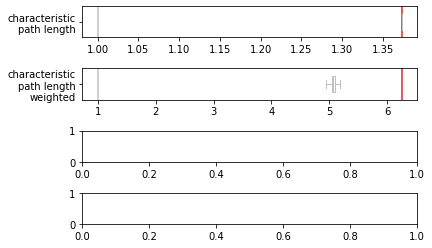

In [15]:
fig, axes = plt.subplots(4, 1)
axes = iter(axes.flatten())
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

ax = next(axes)
ax.boxplot(charpath_length_rand, vert=False, widths=0.5, 
           boxprops={'color': 'silver'}, medianprops={'color': 'silver'}, 
           capprops={'color': 'silver'}, whiskerprops={'color': 'silver'}, showfliers=False)
ax.axvline(x=1, color='silver')
ax.axvline(x=charpath_length, color='tab:red')
# sns.despine(top=True, right=True, left=True, bottom=False, offset=10, trim=False)
ax.set_yticklabels(["characteristic\npath length"])

ax = next(axes)
ax.boxplot(charpath_length_wei_rand, vert=False, widths=0.5, 
           boxprops={'color': 'silver'}, medianprops={'color': 'silver'}, 
           capprops={'color': 'silver'}, whiskerprops={'color': 'silver'}, showfliers=False)
ax.axvline(x=1, color='silver')
ax.axvline(x=charpath_length_wei, color='tab:red')
# sns.despine(top=True, right=True, left=True, bottom=False, offset=10, trim=False)
ax.set_yticklabels(["characteristic\npath length\nweighted"])


In [16]:
degrees_in, degrees_out, _ = bc.degree.degrees_dir(conn_mat)
degrees_in_sorted, labels_in = zip(*sorted(zip(degrees_in, labels), reverse=True))
degrees_out_sorted, labels_out = zip(*sorted(zip(degrees_out, labels), reverse=True))

[Text(0.5, 1.0, 'out degree / in degree')]

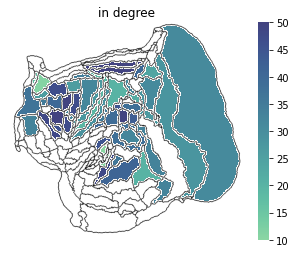

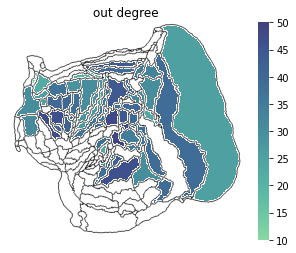

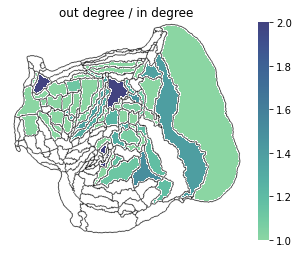

In [17]:
fig, ax, cb = plot_flatmap(degrees_in, cmap=cmap_seq2, vmin=10, vmax=50)
ax.set(title="in degree")


fig, ax, cb = plot_flatmap(degrees_out, cmap=cmap_seq2, vmin=10, vmax=50)
ax.set(title="out degree")

fig, ax, cb = plot_flatmap(degrees_out/degrees_in, cmap=cmap_seq2, vmin=1, vmax=2)
ax.set(title="out degree / in degree")

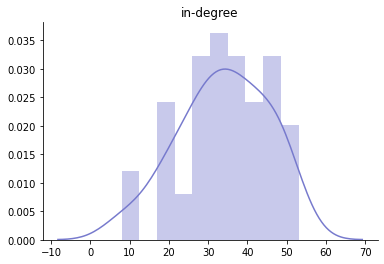

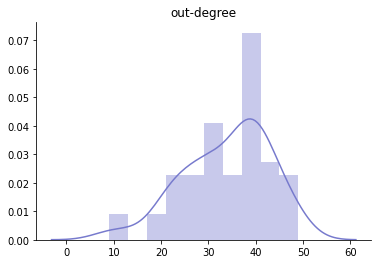

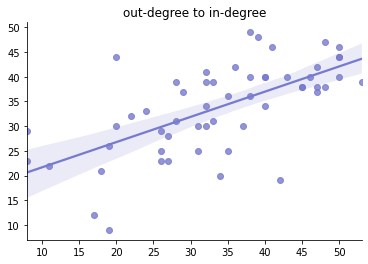

In [18]:
# in-degree distribution
fig, ax = plt.subplots()
sns.distplot(degrees_in, bins=10, color='#777acd', ax=ax)
plt.title('in-degree')
sns.despine(top=True, right=True, left=False, bottom=False)

# out-degree distribution
fig, ax = plt.subplots()
sns.distplot(degrees_out, bins=10, color='#777acd', ax=ax)
plt.title('out-degree')
sns.despine(top=True, right=True, left=False, bottom=False)

# in-degree to out-degree scatter
fig, ax = plt.subplots()
sns.regplot(x=degrees_in, y=degrees_out, color='#777acd', ax=ax)
plt.title('out-degree to in-degree')
sns.despine(top=True, right=True, left=False, bottom=False)

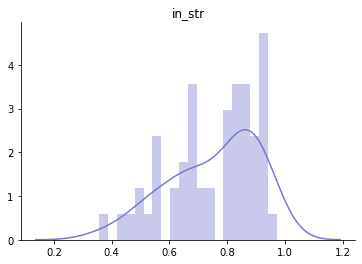

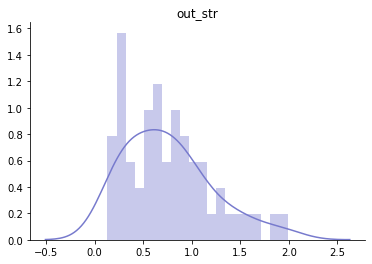

In [19]:
in_str, out_str, _ = bc.degree.strengths_dir(conn_mat)

fig, ax = plt.subplots()
sns.distplot(in_str, bins=20, color='#777acd', ax=ax)
plt.title('in_str')
sns.despine(top=True, right=True, left=False, bottom=False)

# out-degree distribution
fig, ax = plt.subplots()
sns.distplot(out_str, bins=20, color='#777acd', ax=ax)
plt.title('out_str')
sns.despine(top=True, right=True, left=False, bottom=False)

[Text(0.5, 1.0, 'out_str')]

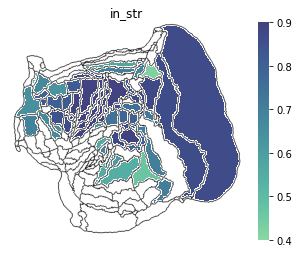

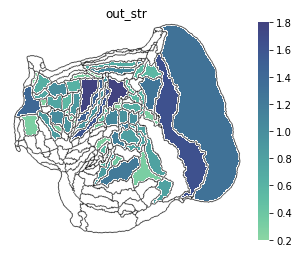

In [20]:
fig, ax, cb = plot_flatmap(in_str, cmap=cmap_seq2, vmin=0.4, vmax=0.9)
ax.set(title="in_str")


fig, ax, cb = plot_flatmap(out_str, cmap=cmap_seq2, vmin=0.2, vmax=1.8)
ax.set(title="out_str")